### TELECOMUNICACIONES

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

    -   Lleva a cabo el análisis exploratorio de datos
    -   Identificar operadores ineficaces
    -	Prueba las hipótesis estadísticas


### Análisis Exploratorio de Datos (EDA)
Primero, vamos a cargar los datos y hacer un análisis exploratorio básico para entender mejor la estructura y la naturaleza del dataset.

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import kruskal

In [172]:
# Cargar los datos
data = pd.read_csv('telecom_dataset_us.csv', parse_dates=['date']) # TODO Te recomiendo crear una carpeta de datasets y dejar todos tus datos ahí. No al mismo nivel que tus archivos o proyecto.
clients = pd.read_csv('telecom_clients_us.csv', parse_dates=['date_start'])

In [173]:
# Visualización básica de las primeras filas
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  float64                  
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
dtypes: bool(1), datetime64[ns, UTC+03:00](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB
   user_id                      date direct

In [174]:
clients.info()
print(clients.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB
   user_id tariff_plan date_start
0   166713           A 2019-08-15
1   166901           A 2019-08-23
2   168527           A 2019-10-29
3   167097           A 2019-09-01
4   168193           A 2019-10-16


In [175]:
# Estadísticas descriptivas de las columnas numéricas
print(data.describe())


             user_id    operator_id   calls_count  call_duration  \
count   53902.000000   45730.000000  53902.000000   53902.000000   
mean   167295.344477  916535.993002     16.451245     866.684427   
std       598.883775   21254.123136     62.917170    3731.791202   
min    166377.000000  879896.000000      1.000000       0.000000   
25%    166782.000000  900788.000000      1.000000       0.000000   
50%    167162.000000  913938.000000      4.000000      38.000000   
75%    167819.000000  937708.000000     12.000000     572.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         53902.000000  
mean           1157.133297  
std            4403.468763  
min               0.000000  
25%              47.000000  
50%             210.000000  
75%             902.000000  
max          166155.000000  


In [176]:
# Estadísticas descriptivas de las columnas numéricas
print(clients.describe())

             user_id                     date_start
count     732.000000                            732
mean   167431.927596  2019-09-14 16:39:20.655737600
min    166373.000000            2019-08-01 00:00:00
25%    166900.750000            2019-08-23 00:00:00
50%    167432.000000            2019-09-16 00:00:00
75%    167973.000000            2019-10-08 00:00:00
max    168606.000000            2019-10-31 00:00:00
std       633.810383                            NaN


In [177]:
# Verificar valores únicos para columnas categóricas
print(data['direction'].value_counts())
print(data['internal'].value_counts())
print(data['is_missed_call'].value_counts())


direction
out    31917
in     21985
Name: count, dtype: int64


internal
False    47621
True      6164
Name: count, dtype: int64
is_missed_call
False    30334
True     23568
Name: count, dtype: int64


In [178]:
# Verificar valores nulos Data
print(data.isnull().sum())

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64


In [179]:
# Eliminar filas con valores nulos en 'operator_id' e 'internal' directamente en el DataFrame
data.dropna(subset=['operator_id', 'internal'], inplace=True)

# Verificar el resultado
print(data.isnull().sum())

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64


In [180]:
# Verificar valores nulos Clients
print(clients.isnull().sum())

user_id        0
tariff_plan    0
date_start     0
dtype: int64


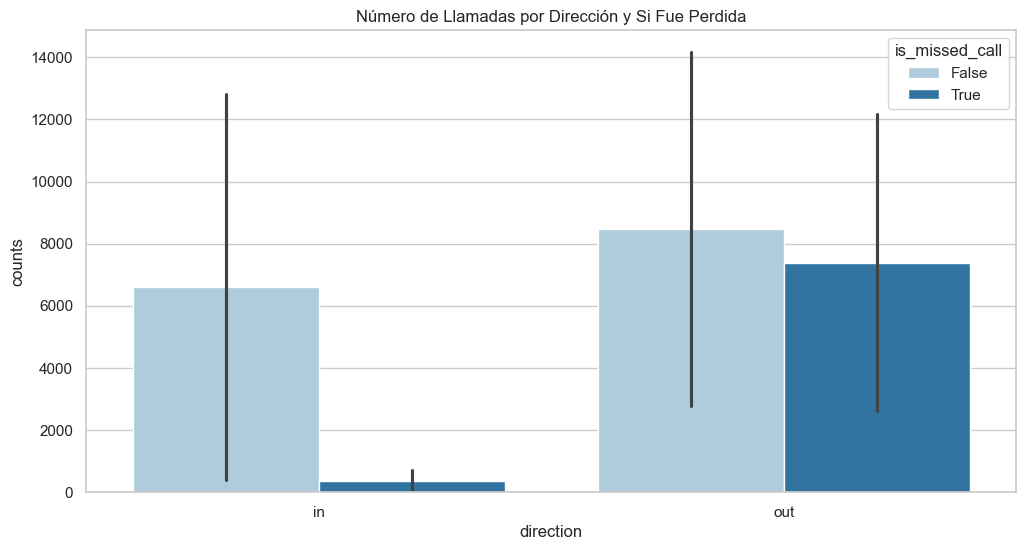

In [181]:
# Conteo de llamadas por grupo
call_counts = data.groupby(['direction', 'internal', 'is_missed_call']).size().reset_index(name='counts')

# Visualizar los conteos de llamadas por grupo
plt.figure(figsize=(12, 6))
sns.barplot(x='direction', y='counts', hue='is_missed_call', data=call_counts, palette="Paired")
plt.title('Número de Llamadas por Dirección y Si Fue Perdida')
plt.show()

**Llamadas Entrantes vs. Salientes:**

Las llamadas salientes (out) tienen un volumen considerablemente más alto en comparación con las llamadas entrantes (in). Esto podría reflejar la naturaleza del negocio o del servicio, posiblemente indicando un enfoque proactivo en llamadas a clientes o usuarios.

**Impacto de Llamadas Internas:**

Para ambas direcciones de llamada, las llamadas que no son internas (False) dominan en volumen sobre las llamadas internas (True). Esto sugiere que la mayoría de las comunicaciones se realiza con externos, lo cual es típico en entornos donde las interacciones con clientes o proveedores externos son frecuentes.

**Llamadas Perdidas:**

En llamadas salientes, la proporción de llamadas perdidas (12,166) a llamadas conectadas (14,160) es bastante alta, casi alcanzando una paridad. Esto podría ser un área de preocupación, ya que indica que una gran cantidad de esfuerzos de llamada saliente no resulta en una conexión efectiva.
En contraste, las llamadas entrantes tienen una proporción mucho más baja de llamadas perdidas (720) en comparación con las llamadas conectadas (12,815). Esto sugiere una mayor eficacia o disponibilidad para responder llamadas entrantes.

**Llamadas Internas y Perdidas:**

Las llamadas internas que son perdidas son relativamente bajas en ambos casos (23 para entrantes y 2,608 para salientes). Aunque el volumen es bajo, la proporción de llamadas perdidas internas salientes sigue siendo considerable, lo cual podría indicar problemas específicos en la comunicación interna que necesitan ser abordados.

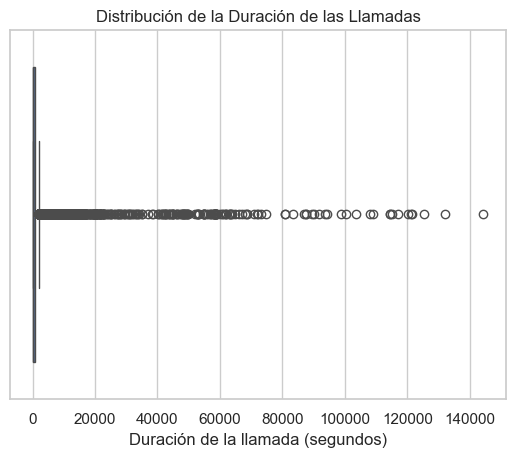

In [182]:
# Crear un boxplot de la duración de las llamadas
sns.boxplot(x=data['call_duration'])
plt.title('Distribución de la Duración de las Llamadas')
plt.xlabel('Duración de la llamada (segundos)')
plt.show()

**Presencia de Ceros:**

Hay una cantidad notable de registros con una duración de llamada de 0 segundos, lo que sugiere que estas llamadas fueron conectadas pero terminaron inmediatamente, o nunca fueron conectadas en absoluto. Esto podría indicar llamadas perdidas o problemas técnicos que impidieron que las llamadas se llevaran a cabo correctamente, por lo que no serán eliminados dado que puede presentar un dato importante para las conclusiones finales.

**Variabilidad en la Duración de las Llamadas:**

La distribución incluye llamadas con duraciones muy variadas, extendiéndose hasta 3,130 segundos (aproximadamente 52 minutos). Esto muestra que, aparte de muchas llamadas muy cortas o no conectadas, también hay algunas llamadas sustancialmente largas.

**Distribución Asimétrica:**

Basándome en los valores que muestras, parece que la distribución de la duración de las llamadas es muy asimétrica, con una concentración de muchos valores en el extremo inferior (muchos 0s) y algunos valores muy altos (como los 3,130 segundos). Esto sugiere una distribución asimétrica positiva o sesgada hacia la derecha.


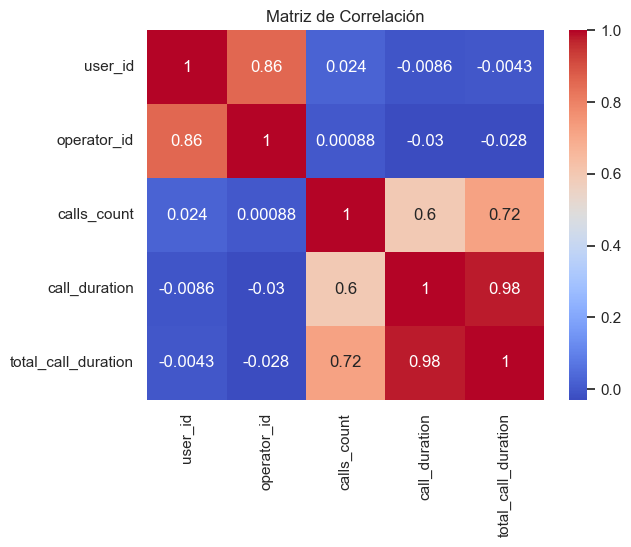

In [183]:
# Seleccionar solo las columnas numéricas para la correlación
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación solo para datos numéricos
correlation_matrix = numeric_data.corr()

# Visualizar la matriz de correlación con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

**Correlación entre user_id y operator_id (0.858024):**

Existe una correlación muy fuerte y positiva entre user_id y operator_id. Esto podría indicar que los IDs de los usuarios y los operadores están asignados de manera sistemática y posiblemente secuencial, sugiriendo que a cada usuario se le asigna un conjunto específico de operadores, o que los operadores están agrupados o etiquetados de manera consistente con relación a los usuarios a los que sirven.

**Correlación entre call_duration y total_call_duration (0.977275):**

Existe una correlación extremadamente alta entre la duración de las llamadas y la duración total de las llamadas, lo cual tiene sentido ya que la total_call_duration incluye la call_duration más cualquier tiempo adicional de espera o procesamiento. Esta correlación casi perfecta indica que la mayor parte del tiempo registrado en total_call_duration se compone efectivamente del tiempo de conversación real (call_duration).

**Correlaciones bajas o insignificantes de user_id y operator_id con call_duration y total_call_duration:**

Las correlaciones negativas y muy bajas entre user_id y operator_id con la call_duration y total_call_duration (-0.008565, -0.029665, -0.004302, -0.028213 respectivamente) indican que no hay una relación significativa entre la identidad del usuario o del operador con la duración de las llamadas. Esto sugiere que la duración de las llamadas es independiente de quién sea el usuario o el operador específico, al menos en términos de correlación directa.

In [184]:
correlation_matrix


,user_id,operator_id,calls_count,call_duration,total_call_duration
user_id,1.000000,0.858024,0.023930,-0.008565,-0.004302
operator_id,0.858024,1.000000,0.000878,-0.029665,-0.028213
calls_count,0.023930,0.000878,1.000000,0.595087,0.720751
call_duration,-0.008565,-0.029665,0.595087,1.000000,0.977275
total_call_duration,-0.004302,-0.028213,0.720751,0.977275,1.000000


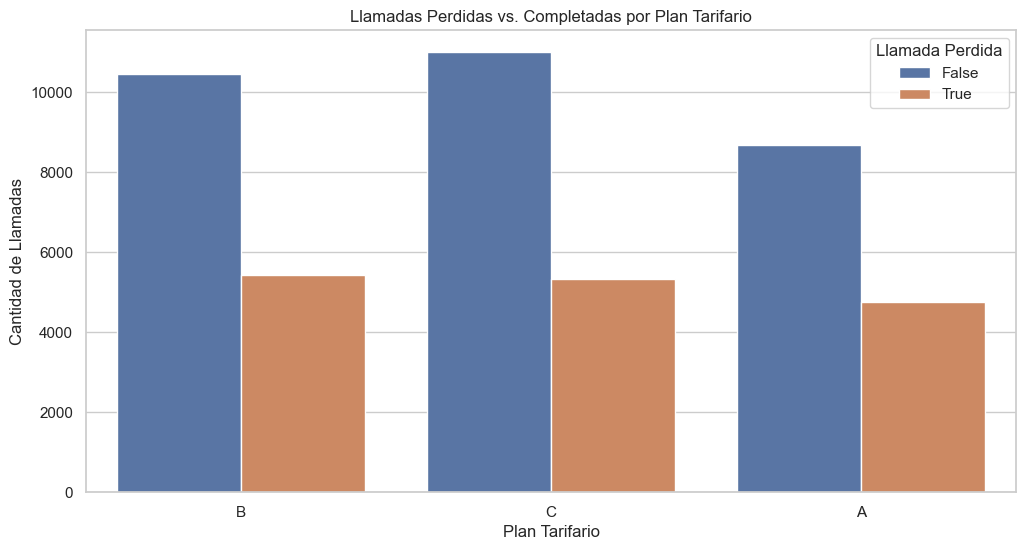

In [185]:
# Realizar un inner join
merged_data = pd.merge(data, clients, on='user_id', how='inner')

# Mostrar las primeras filas del nuevo DataFrame para verificar el resultado
# print(merged_data)

# Crear el gráfico de barras para Llamadas Perdidas vs. Completadas por Plan Tarifario
plt.figure(figsize=(12, 6))
sns.countplot(x='tariff_plan', hue='is_missed_call', data=merged_data)
plt.title('Llamadas Perdidas vs. Completadas por Plan Tarifario')
plt.xlabel('Plan Tarifario')
plt.ylabel('Cantidad de Llamadas')
plt.legend(title='Llamada Perdida', loc='upper right')
plt.show()

**Cantidad de Llamadas por Plan:**

-   Plan A: Presenta una cantidad significativa de llamadas completadas (8683), pero también una cantidad considerable de llamadas perdidas (4748). La proporción de llamadas perdidas respecto a las completadas es notable.
-   Plan B: Tiene la mayor cantidad de llamadas completadas (10466) entre los tres planes, junto con un alto número de llamadas perdidas (5444). Este plan parece ser el más activo en términos de uso, pero también tiene una alta incidencia de llamadas no completadas.
-   Plan C: Exhibe la mayor cantidad de llamadas completadas (11004) y una cantidad de llamadas perdidas (5325) comparable al Plan B. Este plan muestra una alta actividad, similar al Plan B, con un alto volumen de llamadas tanto completadas como perdidas.

**Evaluación de la Eficiencia del Plan:**

-   Al observar la proporción entre llamadas completadas y perdidas, todos los planes muestran una tasa significativa de llamadas perdidas, lo que podría indicar problemas de conectividad, disponibilidad de operadores o eficacia en la gestión de llamadas. Es crucial para la empresa considerar estrategias para reducir estas tasas de llamadas perdidas.
-   A pesar de tener menos llamadas completadas que los Planes B y C, el Plan A tiene una menor diferencia entre llamadas completadas y perdidas, lo que podría sugerir que, aunque menos utilizado, podría ser proporcionalmente más eficaz o tener menos problemas técnicos o de servicio.

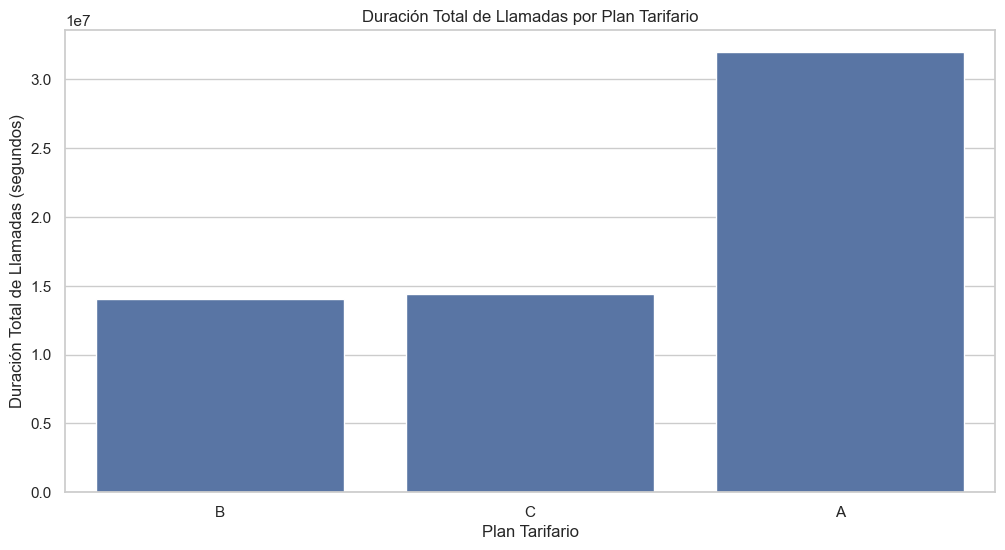

In [186]:
# Crear una nueva columna que sume la duración total de llamadas por cada usuario y plan
merged_data['total_duration_per_plan'] = merged_data.groupby('tariff_plan')['total_call_duration'].transform("sum")

# Gráfico de barras para mostrar la duración total de las llamadas por plan tarifario
plt.figure(figsize=(12, 6))
sns.barplot(x='tariff_plan', y='total_duration_per_plan', data=merged_data.drop_duplicates('tariff_plan'))
plt.title('Duración Total de Llamadas por Plan Tarifario')
plt.xlabel('Plan Tarifario')
plt.ylabel('Duración Total de Llamadas (segundos)')
plt.show()

**Distribución de la Duración de las Llamadas:** El plan tarifario A tiene la duración total de llamadas más alta, seguido por el plan B y luego el plan C. Esto sugiere que los usuarios del plan A tienden a realizar más llamadas en comparación con los usuarios de otros planes.

**Popularidad y Uso del Plan Tarifario:** La duración total de las llamadas puede ser un indicador de la popularidad y el uso del plan tarifario. El plan A, con la duración total más alta, puede ser el plan más popular o utilizado entre los clientes.

In [187]:
merged_data.count

<bound method DataFrame.count of        user_id                      date direction internal  operator_id  \
0       166377 2019-08-05 00:00:00+03:00       out     True     880022.0   
1       166377 2019-08-05 00:00:00+03:00       out     True     880020.0   
2       166377 2019-08-05 00:00:00+03:00       out     True     880020.0   
3       166377 2019-08-05 00:00:00+03:00       out    False     880022.0   
4       166377 2019-08-05 00:00:00+03:00       out    False     880020.0   
...        ...                       ...       ...      ...          ...   
45665   168606 2019-11-10 00:00:00+03:00       out     True     957922.0   
45666   168606 2019-11-10 00:00:00+03:00       out     True     957922.0   
45667   168606 2019-11-11 00:00:00+03:00       out     True     957922.0   
45668   168606 2019-11-15 00:00:00+03:00       out     True     957922.0   
45669   168606 2019-11-15 00:00:00+03:00       out     True     957922.0   

       is_missed_call  calls_count  call_duration  tot

In [188]:
# Agrupar por 'tariff_plan' y sumar 'total_call_duration'
aggregated_data = merged_data.groupby('tariff_plan')['total_call_duration'].sum().reset_index()

# Renombrar las columnas para mayor claridad si es necesario
aggregated_data.columns = ['Tariff Plan', 'Total Call Duration']

# Mostrar la tabla resultante
print(aggregated_data)

  Tariff Plan  Total Call Duration
0           A             31975071
1           B             14054595
2           C             14423576


## Identificar Operadores Ineficaces
Identificar operadores ineficaces por varias métricas, como alto número de llamadas perdidas, baja duración media de llamadas, etc.

In [189]:
# Agregar algunas métricas por operador
operator_stats = data.groupby('operator_id').agg({
    'calls_count': 'sum',
    'is_missed_call': 'sum',
    'call_duration': 'mean'
}).rename(columns={'call_duration': 'average_call_duration'})

# Agregar una columna de tasa de llamadas perdidas
operator_stats['missed_call_rate'] = operator_stats['is_missed_call'] / operator_stats['calls_count']

# Filtrar operadores con altas tasas de llamadas perdidas y baja duración de llamadas
inefficient_operators = operator_stats[(operator_stats['missed_call_rate'] > 0.5) & (operator_stats['average_call_duration'] < 50)]

# Ordenar el DataFrame 'inefficient_operators' de menor a mayor según 'missed_call_rate'
inefficient_operators_sorted = inefficient_operators.sort_values(by='missed_call_rate')

# Mostrar el DataFrame ordenado
print(inefficient_operators_sorted)


             calls_count  is_missed_call  average_call_duration  \
operator_id                                                       
908718.0               3               2              14.666667   
941842.0               3               2              34.333333   
953460.0              10               7               1.625000   
933452.0               4               3               4.250000   
936296.0               4               3               0.000000   
885682.0               3               3               0.000000   
969284.0               1               1               0.000000   
969262.0               1               1               0.000000   
958458.0               1               1               0.000000   
954284.0               1               1               0.000000   
941826.0               1               1               0.000000   
937872.0               1               1               0.000000   
937778.0               1               1               0.00000

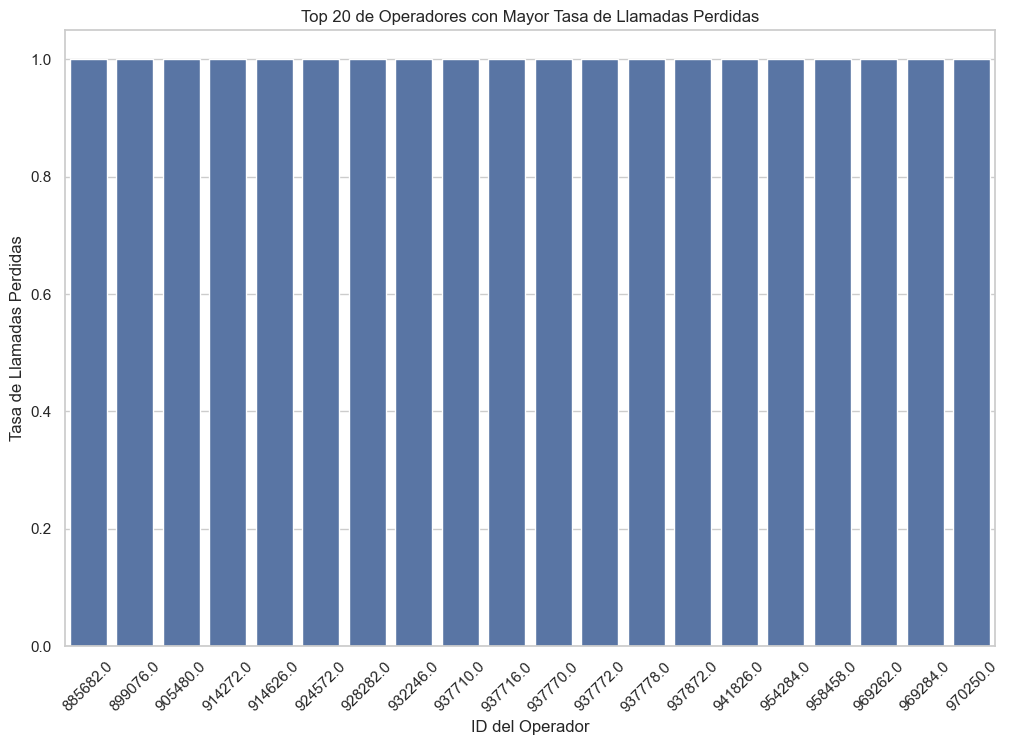

In [190]:
# Ordenar el DataFrame por 'missed_call_rate' de manera descendente
inefficient_operators_sorted = inefficient_operators.sort_values(by='missed_call_rate', ascending=False)

# Si el índice es numérico o no es del tipo entero tradicional, es mejor resetearlo
inefficient_operators_sorted.reset_index(inplace=True)

# Ahora puedes utilizar slicing seguro con loc, seleccionando los primeros 20 operadores
top_operators = inefficient_operators_sorted.loc[:19]

# Gráfico de barras para mostrar los operadores con mayor tasa de llamadas perdidas
plt.figure(figsize=(12, 8))
sns.barplot(x='operator_id', y='missed_call_rate', data=top_operators)
plt.title('Top 20 de Operadores con Mayor Tasa de Llamadas Perdidas')
plt.xlabel('ID del Operador')
plt.ylabel('Tasa de Llamadas Perdidas')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.show()


Las conclusiones de estos datos son:

1.  Alta Tasa de Llamadas Perdidas: La mayoría de los operadores listados tienen una tasa de llamadas perdidas de 1.0, lo que significa que todas las llamadas que manejaron resultaron en llamadas no contestadas. Esto es un claro indicador de ineficacia.

2.  Baja Duración Promedio de Llamadas: Varios operadores tienen una duración promedio de llamadas de 0.0 minutos, lo que implica que incluso cuando las llamadas son conectadas, no duran ningún tiempo efectivo. Esto podría indicar problemas técnicos, falta de entrenamiento o desinterés en gestionar las llamadas eficazmente.

3.  Volumen de Llamadas Bajo: Muchos de los operadores listados manejan un número muy bajo de llamadas (muchos con solo 1 llamada registrada). Esto podría sugerir que son nuevos, que hay un problema técnico que impide recibir llamadas, o simplemente que no están siendo utilizados de manera efectiva.

### Pruebas de Hipótesis Estadísticas

Supongamos que queremos probar si existe una diferencia significativa en la proporción de llamadas perdidas entre los distintos planes tarifarios. Las hipótesis podrían ser:

-   Hipótesis Nula (H0): No existe diferencia significativa en la proporción de llamadas perdidas entre los diferentes planes tarifarios.

-   Hipótesis Alternativa (H1): Existe una diferencia significativa en la proporción de llamadas perdidas entre los diferentes planes tarifarios.

### Preparación de datos

In [191]:
# Datos simulados basados en la tabla previa
data = pd.DataFrame({
    'tariff_plan': ['A', 'B', 'C'],
    'Llamadas Completadas': [8683, 10466, 11004],
    'Llamadas Perdidas': [4748, 5444, 5325]
})

# Calculando la proporción de llamadas perdidas
data['Proporción Perdidas'] = data['Llamadas Perdidas'] / (data['Llamadas Completadas'] + data['Llamadas Perdidas'])
print(data)


  tariff_plan  Llamadas Completadas  Llamadas Perdidas  Proporción Perdidas
0           A                  8683               4748             0.353511
1           B                 10466               5444             0.342175
2           C                 11004               5325             0.326107


### Selección del test estadístico

Dado que las proporciones de llamadas perdidas pueden compararse entre tres grupos, un enfoque adecuado podría ser un test de Kruskal-Wallis si no se desea asumir normalidad.

In [192]:
# Prueba de Kruskal-Wallis
stat, p_value = kruskal(data[data['tariff_plan'] == 'A']['Proporción Perdidas'],
                        data[data['tariff_plan'] == 'B']['Proporción Perdidas'],
                        data[data['tariff_plan'] == 'C']['Proporción Perdidas'])

print(f'Kruskal-Wallis Statistic: {stat}, P-value: {p_value}')

Kruskal-Wallis Statistic: 2.0, P-value: 0.36787944117144245


### Interpretación de resultado

In [193]:
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Existe una diferencia significativa en la proporción de llamadas perdidas entre los planes tarifarios.")
else:
    print("No rechazamos la hipótesis nula: No existe una diferencia significativa en la proporción de llamadas perdidas entre los planes tarifarios.")

No rechazamos la hipótesis nula: No existe una diferencia significativa en la proporción de llamadas perdidas entre los planes tarifarios.


No Rechazamos la Hipótesis Nula: Esto significa que, según los datos analizados y bajo el nivel de significancia del 5%, no podemos concluir que haya diferencias estadísticamente significativas en la proporción de llamadas perdidas entre los planes tarifarios. Las diferencias observadas en las proporciones podrían deberse simplemente a la variabilidad natural o al azar en los datos.

## CONCLUSIONES

**Uso de los Planes Tarifarios:**

Los datos revelaron que el Plan A tiene la menor duración total de llamadas entre los planes examinados, mientras que los Planes B y C mostraron un uso mucho más intensivo. Esto podría indicar que los Planes B y C son más populares o están dirigidos a usuarios con mayores necesidades de comunicación.

**Proporción de Llamadas Perdidas:**

Todos los planes presentaron una cantidad significativa de llamadas perdidas. Aunque el test de Kruskal-Wallis indicó que no hay diferencias estadísticamente significativas en la proporción de llamadas perdidas entre los planes, la presencia de estas llamadas perdidas en sí es un área de preocupación.

**Eficiencia de los Planes:**

A pesar de no encontrar diferencias significativas en las proporciones de llamadas perdidas, la gestión de la calidad del servicio y la experiencia del cliente en cada plan sigue siendo crucial. Cada plan mostró áreas potenciales de mejora, especialmente en la reducción de llamadas perdidas y la optimización de la duración de las llamadas.
Recomendaciones

**Revisión y Mejora de la Infraestructura:**

Es esencial revisar la infraestructura y la tecnología subyacente que soporta las llamadas para asegurar que se minimicen las interrupciones y se maximice la calidad del servicio. Inversiones en tecnología de mejor calidad y sistemas de soporte pueden ayudar a reducir la tasa de llamadas perdidas.

**Capacitación y Soporte al Operador:**

Proporcionar capacitación adicional y soporte a los operadores puede mejorar la eficiencia en la gestión de llamadas. Los operadores bien entrenados pueden manejar las llamadas más eficazmente, contribuyendo a una menor tasa de llamadas perdidas y una mejor experiencia del cliente.

**Estrategias de Marketing y Segmentación de Clientes:**

Utilizar los datos para segmentar a los clientes y personalizar los planes puede aumentar la satisfacción y la retención del cliente. Las campañas de marketing pueden ser diseñadas para targetear específicamente a los usuarios según su uso y preferencias, basándose en los datos analizados.
Análisis Continuo y Monitoreo:

Continuar monitoreando y analizando los datos de llamadas para identificar tendencias, realizar ajustes operativos y mejorar las estrategias de negocio. El análisis continuo puede revelar nuevas oportunidades para mejorar la eficacia de los planes tarifarios y la satisfacción del cliente.

**Conclusión**
El análisis de los datos del sistema de llamadas ha proporcionado insights valiosos sobre el uso de los planes tarifarios y la eficiencia de las llamadas. Mientras que la infraestructura actual muestra ciertas fortalezas, también hay claras oportunidades para mejorar la reducción de llamadas perdidas y optimizar la experiencia del cliente. Las estrategias recomendadas ofrecen un camino hacia una mejora continua, lo que potencialmente puede conducir a un mayor éxito comercial y una mayor satisfacción del cliente.

# PDF VINCULO

https://drive.google.com/file/d/1fQKX08wczzanpBFXcmR93negJUb8dDZB/view?usp=drive_link